### Section 2.1: GCN Code Implementation

In this section, we will take the GCN layer we implemented in Section 1.2 and build a complete GCN model. We’ll go beyond the individual layer to design a full Graph Convolutional Network with multiple layers and demonstrate how to train it on a sample dataset.

**Contents:**

1. **Designing a Multi-Layer GCN Model**
2. **Adding Multiple GCN Layers**
3. **Defining the GCN Model Architecture**
4. **Creating a Sample Dataset (Using NetworkX)**
5. **Training the GCN Model**
6. **Evaluating the Model**
7. **Code Walkthrough**

---



### 1. Designing a Multi-Layer GCN Model

- **Objective**: Build a GCN model with multiple layers to enable nodes to aggregate information from farther neighbors.
- **Layer Stacking**:
  - In GCNs, stacking layers allows each node to consider information from more distant nodes.
  - For example, in a two-layer GCN, each node aggregates information from its neighbors and its neighbors’ neighbors.

- **Architecture**:
  - **Input Layer**: Receives the initial node features.
  - **Hidden Layers**: One or more GCN layers to process and propagate information across the graph.
  - **Output Layer**: Generates the final node or graph-level predictions (e.g., node classification).

---



### 2. Adding Multiple GCN Layers

A typical GCN model uses multiple GCN layers. Here’s an example of how to stack two GCN layers.



#### Code Example: Multi-Layer GCN


The GCNLayer given here below is taken from section 1.2.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Initialize a Graph Convolutional Network (GCN) layer.

        Parameters:
        - in_features: Number of input features per node (e.g., feature dimension).
        - out_features: Number of output features per node (e.g., transformed feature dimension).
        """
        super(GCNLayer, self).__init__()

        # Define a linear transformation (weights) for feature transformation
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, node_features, adj_matrix):
        """
        Forward pass for the GCN layer.

        Parameters:
        - node_features: Tensor of shape [num_nodes, in_features] containing the initial features of each node.
        - adj_matrix: Tensor of shape [num_nodes, num_nodes] representing the adjacency matrix of the graph,
                      where adj_matrix[i][j] is 1 if there is an edge from node i to node j, else 0.

        Returns:
        - Updated node features of shape [num_nodes, out_features] after aggregation and transformation.
        """
        # Step 1: Linear transformation of node features
        # Apply a learned linear transformation to each node's features to project to the output feature space
        transformed_features = self.linear(node_features)

        # Step 2: Message Passing
        # Aggregate information from neighboring nodes by matrix-multiplying the adjacency matrix
        # with the transformed features. This computes a weighted sum of neighboring features for each node.
        aggregated_features = torch.matmul(adj_matrix, transformed_features)

        # Step 3: Normalization by Node Degrees
        # Normalize the aggregated features by the degree of each node to maintain scale
        # and prevent nodes with many connections from having disproportionately high values.
        # The degree of a node is the sum of the entries in its row in the adjacency matrix.
        degrees = adj_matrix.sum(dim=1, keepdim=True)  # Compute the degree of each node
        normalized_features = aggregated_features / degrees  # Normalize by dividing aggregated values by degree

        # Step 4: Apply Activation Function
        # Use ReLU activation to introduce non-linearity, which helps the model capture complex relationships.
        return F.relu(normalized_features)


The below class use the above layer

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLayerGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialize a multi-layer Graph Convolutional Network (GCN).

        Parameters:
        - input_dim: Dimension of the input features for each node.
        - hidden_dim: Dimension of the hidden layer's output features.
        - output_dim: Dimension of the final output features for each node.
        """
        super(MultiLayerGCN, self).__init__()

        # Define the first GCN layer
        # This layer transforms the input features to the hidden dimension
        self.gcn1 = GCNLayer(input_dim, hidden_dim)

        # Define the second GCN layer
        # This layer further transforms the features from hidden dimension to output dimension
        self.gcn2 = GCNLayer(hidden_dim, output_dim)

    def forward(self, node_features, adj_matrix):
        """
        Perform a forward pass through the multi-layer GCN.

        Parameters:
        - node_features: Tensor of shape [num_nodes, input_dim] containing initial features of each node.
        - adj_matrix: Tensor of shape [num_nodes, num_nodes] representing the adjacency matrix of the graph.

        Returns:
        - Final transformed node features of shape [num_nodes, output_dim].
        """
        # Step 1: Pass the node features through the first GCN layer
        # The first layer maps the input features to the hidden layer
        x = self.gcn1(node_features, adj_matrix)

        # Step 2: Pass the features through the second GCN layer
        # The second layer maps the hidden features to the final output features
        x = self.gcn2(x, adj_matrix)

        return x


Explanation:


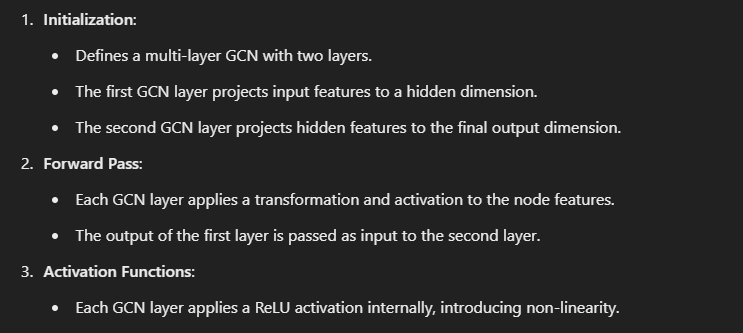


### 3. Defining the GCN Model Architecture

The `MultiLayerGCN` class we defined above is a basic GCN architecture with two layers. For larger and more complex datasets, additional layers can be added as needed.

**Code Snippet**:


In [4]:
# Example configuration for initializing a multi-layer GCN model
input_dim = 3       # Input dimension of node features, e.g., 3 initial features per node
hidden_dim = 4      # Dimension of the hidden layer, used in the first GCN layer
output_dim = 2      # Output dimension for the final layer, e.g., 2 for binary classification tasks

# Initialize the multi-layer GCN model with the specified configuration
gcn_model = MultiLayerGCN(input_dim, hidden_dim, output_dim)

# Display the model architecture to verify the configuration
print("Initialized GCN Model:")
print(gcn_model)


Initialized GCN Model:
MultiLayerGCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=3, out_features=4, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=4, out_features=2, bias=True)
  )
)



### 4. Creating a Sample Dataset (Using NetworkX)

To test the GCN model, let’s create a sample graph dataset using the NetworkX library.



1. **Install NetworkX** (if not already installed):


In [5]:
!pip install networkx



2. **Define a Sample Graph**:
   - Use NetworkX to create a small graph with node features and an adjacency matrix.

**Code Example**:



Adjacency Matrix:
tensor([[0., 1., 1., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 1.],
        [1., 0., 1., 0.]])

Node Features:
tensor([[1., 2., 3.],
        [2., 3., 1.],
        [3., 1., 2.],
        [1., 2., 1.]])


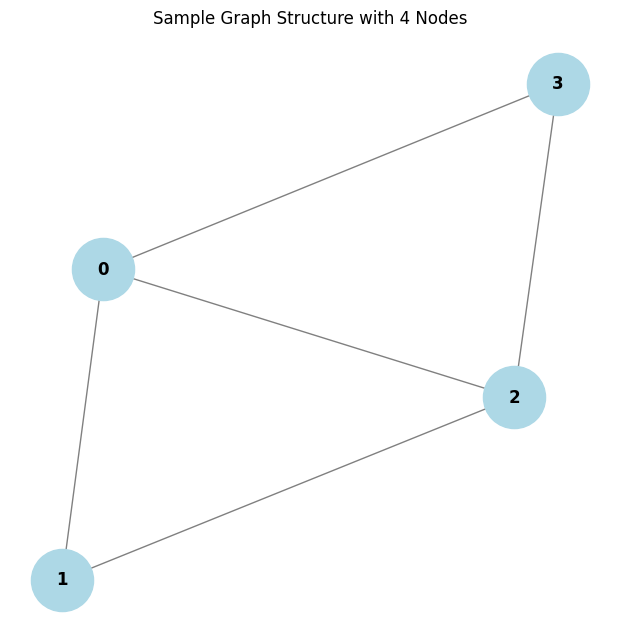

In [6]:
import networkx as nx
import torch
import matplotlib.pyplot as plt

# Create a sample undirected graph with 4 nodes
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)])  # Add edges between nodes

# Define node features (randomly initialized for demonstration)
# Each row represents the feature vector for a node in the graph
node_features = torch.tensor([
    [1.0, 2.0, 3.0],  # Features for Node 0
    [2.0, 3.0, 1.0],  # Features for Node 1
    [3.0, 1.0, 2.0],  # Features for Node 2
    [1.0, 2.0, 1.0]   # Features for Node 3
], dtype=torch.float32)

# Convert the graph to an adjacency matrix format suitable for PyTorch
# nx.adjacency_matrix() returns a sparse matrix, so we convert it to a dense format and then to a tensor
adj_matrix = torch.tensor(nx.adjacency_matrix(G).todense(), dtype=torch.float32)

# Print the adjacency matrix to verify the connections
print("Adjacency Matrix:")
print(adj_matrix)

# Print the initial node features for reference
print("\nNode Features:")
print(node_features)

# Visualization of the graph structure
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color="lightblue", node_size=2000, font_size=12, font_weight="bold", edge_color="gray")
plt.title("Sample Graph Structure with 4 Nodes")
plt.show()



- **Node Features**: Initialized randomly or based on the specific use case.
- **Adjacency Matrix**: This matrix represents the connections between nodes, which the GCN uses to propagate information.

---



### 5. Training the GCN Model

For simplicity, let’s assume a node classification task where we predict binary labels for each node. We’ll use a basic training loop in PyTorch.



#### Code Example: Training Loop



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample binary labels for each node (e.g., for a binary classification task)
labels = torch.tensor([0, 1, 0, 1], dtype=torch.long)  # Target labels for each node

# Define loss function and optimizer
# CrossEntropyLoss is used for classification tasks with integer class labels
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer to train the model parameters
# Learning rate is set to 0.01
optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)

# Training configuration
epochs = 20  # Number of epochs for training

# Training loop for the GCN model
for epoch in range(epochs):
    # Forward pass: compute the model output (node predictions) based on node features and adjacency matrix
    outputs = gcn_model(node_features, adj_matrix)

    # Compute loss between model predictions and true labels
    loss = criterion(outputs, labels)

    # Backward pass: compute gradients of the loss with respect to model parameters
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Compute new gradients based on current loss

    # Optimization step: update model parameters
    optimizer.step()

    # Print training progress with current epoch and loss value
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/20], Loss: 0.6931
Epoch [2/20], Loss: 0.6931
Epoch [3/20], Loss: 0.6931
Epoch [4/20], Loss: 0.6931
Epoch [5/20], Loss: 0.6931
Epoch [6/20], Loss: 0.6931
Epoch [7/20], Loss: 0.6931
Epoch [8/20], Loss: 0.6931
Epoch [9/20], Loss: 0.6931
Epoch [10/20], Loss: 0.6931
Epoch [11/20], Loss: 0.6931
Epoch [12/20], Loss: 0.6931
Epoch [13/20], Loss: 0.6931
Epoch [14/20], Loss: 0.6931
Epoch [15/20], Loss: 0.6931
Epoch [16/20], Loss: 0.6931
Epoch [17/20], Loss: 0.6931
Epoch [18/20], Loss: 0.6931
Epoch [19/20], Loss: 0.6931
Epoch [20/20], Loss: 0.6931



**Explanation**:
- Binary Labels: Defines target labels for each node.
- Loss and Optimizer:
    - Uses CrossEntropyLoss for multi-class classification.
    - Applies the Adam optimizer for adaptive learning.
- Training Loop:
    - Each epoch includes a forward pass to get predictions, loss computation, backward pass for gradients, and parameter update.
- Progress Output:
    - Displays the loss after each epoch to track training progress.


### 6. Evaluating the Model

After training, we can evaluate the model’s performance by comparing predicted labels with the true labels.



#### Code Example: Evaluation



In [8]:
# Evaluation phase: obtain predictions without tracking gradients
with torch.no_grad():
    # Forward pass through the GCN model to get output logits for each node
    outputs = gcn_model(node_features, adj_matrix)

    # Get the predicted class for each node by finding the index of the max logit
    _, predicted = torch.max(outputs, dim=1)

# Print predicted and true labels for comparison
print("Predicted Labels:", predicted.numpy())
print("True Labels:", labels.numpy())

# Evaluation Metric: Calculate Accuracy
accuracy = (predicted == labels).sum().item() / labels.size(0)
print(f"Accuracy: {accuracy * 100:.2f}%")


Predicted Labels: [0 0 0 0]
True Labels: [0 1 0 1]
Accuracy: 50.00%



#### Explanation:
1. **Inference with No Gradient Tracking**:
   - Uses `torch.no_grad()` to avoid computing gradients, optimizing memory and speed.
   
2. **Prediction**:
   - `torch.max` selects the index of the maximum logit, representing the predicted class for each node.
   
3. **Accuracy Calculation**:
   - Compares predicted labels with true labels and computes accuracy, a simple metric for classification performance.
